**NASA POWER Climate Data Analysis: Dhahran (2025)**

This project uses daily NASA POWER data (2025) to compute and visualize monthly average solar radiation in Dhahran, Saudi Arabia. The analysis highlights trends under clear-sky vs. all-sky conditions, relevant for energy modeling and climate research.


In [ ]:
from google.colab import files
uploaded = files.upload()

import pandas as pd

# Load and inspect the file manually
with open('POWER_Point_Daily_20250101_20250730_026d26N_050d07E_LST.csv', 'r') as file:
    for i in range(20):
        print(f"{i}: {file.readline()}")

Saving POWER_Point_Daily_20250101_20250730_026d26N_050d07E_LST.csv to POWER_Point_Daily_20250101_20250730_026d26N_050d07E_LST.csv
0: -BEGIN HEADER-

1: NASA/POWER Source Native Resolution Daily Data 

2: Dates (month/day/year): 01/01/2025 through 07/30/2025 in LST

3: Location: latitude  26.2577   longitude 50.07 

4: elevation from MERRA-2: Average for 0.5 x 0.625 degree lat/lon region = 13.68 meters

5: The value for missing source data that cannot be computed or is outside of the sources availability range: -999 

6: parameter(s): 

7: ALLSKY_SFC_SW_DWN     CERES SYN1deg All Sky Surface Shortwave Downward Irradiance (kW-hr/m^2/day) 

8: PS                    MERRA-2 Surface Pressure (kPa) 

9: T2M                   MERRA-2 Temperature at 2 Meters (C) 

10: WS10M                 MERRA-2 Wind Speed at 10 Meters (m/s) 

11: CLRSKY_SFC_SW_DWN     CERES SYN1deg Clear Sky Surface Shortwave Downward Irradiance (kW-hr/m^2/day) 

12: -END HEADER-

13: YEAR,MO,DY,ALLSKY_SFC_SW_DWN,PS,T2M,WS10

In [ ]:
# Load the CSV file properly (skip header)
df = pd.read_csv('POWER_Point_Daily_20250101_20250730_026d26N_050d07E_LST.csv', skiprows=12)

# Show the first 5 rows
df.head()

-END HEADER-
YEAR MO DY ALLSKY_SFC_SW_DWN PS     T2M   WS10M  CLRSKY_SFC_SW_DWN
2025 1  1  3.2573            101.88 16.86 7.16              3.3482
        2  3.4049            102.15 15.67 7.29              3.4702
        3  3.6629            102.25 14.65 6.64               3.857
        4  3.978             102.22 14.58 5.2               4.2084

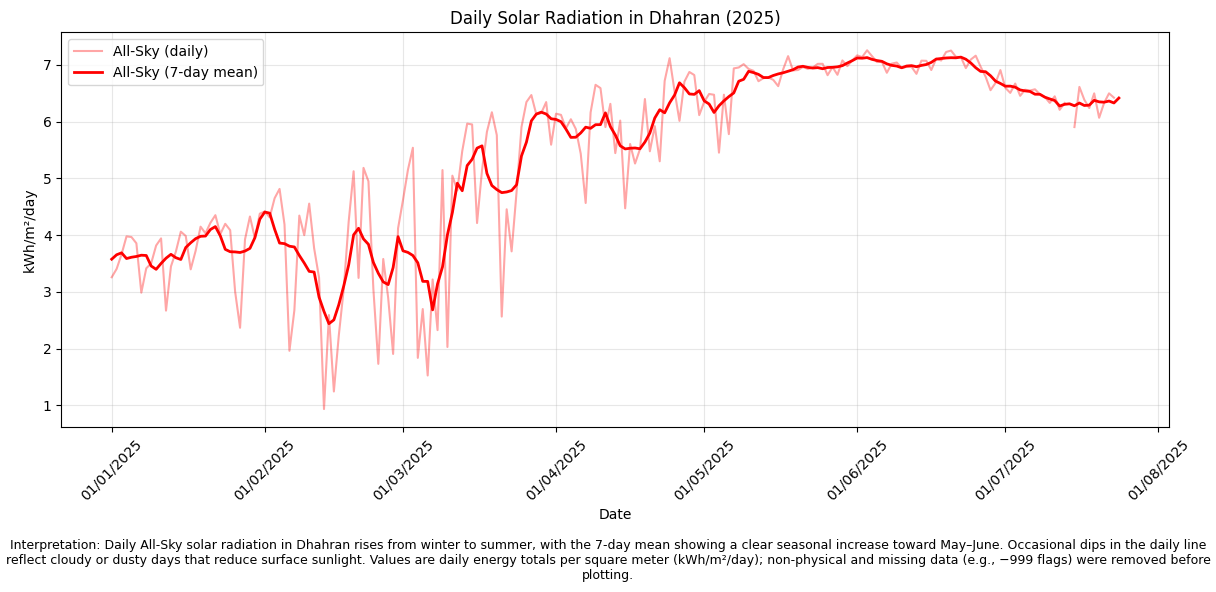

In [ ]:
# ==== Daily Solar Radiation with Embedded Interpretation (NASA POWER) ====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1) Load CSV (skip POWER metadata rows)
csv_path = 'POWER_Point_Daily_20250101_20250730_026d26N_050d07E_LST.csv'
df = pd.read_csv(csv_path, skiprows=13)

# 2) Tidy columns
df.columns = df.columns.str.strip()
df = df.rename(columns={
    'ALLSKY_SFC_SW_DWN': 'ALLSKY',
    'CLRSKY_SFC_SW_DWN': 'CLRSKY',
    'YEAR': 'year', 'MO': 'month', 'DY': 'day'
})

# 3) Clean radiation columns: cast to numeric, drop sentinels and impossible values
for c in ['ALLSKY', 'CLRSKY']:
    if c in df:
        df[c] = pd.to_numeric(df[c], errors='coerce')
        df[c] = df[c].replace([-999, -999.0, -9999, -9999.0], np.nan)  # NASA missing flags
        df[c] = df[c].mask(df[c] <= 0)      # daily totals shouldn't be ≤ 0 kWh/m²/day
        df[c] = df[c].mask(df[c] > 15)      # sanity cap to avoid outliers

# 4) Build a real date index
if {'year','month','day'}.issubset(df.columns):
    dates = pd.to_datetime(df[['year','month','day']])
else:
    # fallback if date parts are missing
    dates = pd.date_range('2025-01-01', periods=len(df), freq='D')

df = df.assign(Date=dates).set_index('Date').sort_index()

# 5) Optional smoothing for readability
df['ALLSKY_7d'] = df['ALLSKY'].rolling(7, center=True, min_periods=3).mean()

# 6) Plot daily (light) + 7-day mean (bold), with calendar dates
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(df.index, df['ALLSKY'], label='All-Sky (daily)', alpha=0.35, color='red')
ax.plot(df.index, df['ALLSKY_7d'], label='All-Sky (7-day mean)', linewidth=2, color='red')

ax.set_title('Daily Solar Radiation in Dhahran (2025)')
ax.set_xlabel('Date')
ax.set_ylabel('kWh/m²/day')
ax.grid(True, alpha=0.3)
ax.legend()

# X-axis format: DD/MM/YYYY with monthly ticks
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.xticks(rotation=45)

fig.tight_layout()

# 7) Embedded interpretation caption (becomes part of the image)
caption = (
    "Interpretation: Daily All-Sky solar radiation in Dhahran rises from winter to summer, with the 7-day mean "
    "showing a clear seasonal increase toward May–June. Occasional dips in the daily line reflect cloudy or dusty "
    "days that reduce surface sunlight. Values are daily energy totals per square meter (kWh/m²/day); non-physical "
    "and missing data (e.g., −999 flags) were removed before plotting."
)

# Add space below for caption and insert it
plt.subplots_adjust(bottom=0.28)
plt.figtext(0.5, 0.03, caption, ha='center', wrap=True, fontsize=9)

# 8) Save and show (image includes the caption)
plt.savefig('daily_allsky_with_caption.png', dpi=300, bbox_inches='tight')
plt.show()



ALLSKY average (clipped): 5.43
CLRSKY average (clipped): 5.73


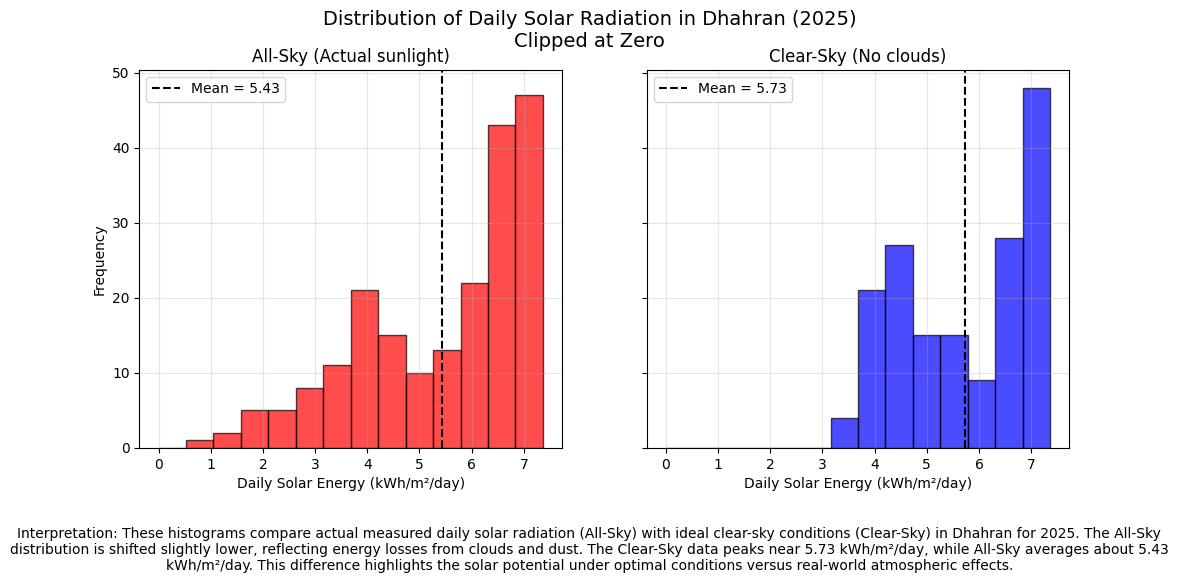

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Clip negatives to zero
df['ALLSKY'] = df['ALLSKY'].clip(lower=0)
df['CLRSKY'] = df['CLRSKY'].clip(lower=0)

# Calculate averages
allsky_mean = df['ALLSKY'].mean()
clrsky_mean = df['CLRSKY'].mean()

print(f"ALLSKY average (clipped): {allsky_mean:.2f}")
print(f"CLRSKY average (clipped): {clrsky_mean:.2f}")

# Plot histograms side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Common bin range
bins = np.linspace(0, max(df['ALLSKY'].max(), df['CLRSKY'].max()), 15)

# ALLSKY histogram
axes[0].hist(df['ALLSKY'], bins=bins, color='red', alpha=0.7, edgecolor='black')
axes[0].axvline(allsky_mean, color='black', linestyle='dashed', linewidth=1.5,
                label=f'Mean = {allsky_mean:.2f}')
axes[0].set_title('All-Sky (Actual sunlight)')
axes[0].set_xlabel('Daily Solar Energy (kWh/m²/day)')
axes[0].set_ylabel('Frequency')
axes[0].grid(alpha=0.3)
axes[0].legend()

# CLRSKY histogram
axes[1].hist(df['CLRSKY'], bins=bins, color='blue', alpha=0.7, edgecolor='black')
axes[1].axvline(clrsky_mean, color='black', linestyle='dashed', linewidth=1.5,
                label=f'Mean = {clrsky_mean:.2f}')
axes[1].set_title('Clear-Sky (No clouds)')
axes[1].set_xlabel('Daily Solar Energy (kWh/m²/day)')
axes[1].grid(alpha=0.3)
axes[1].legend()

# Overall title
plt.suptitle('Distribution of Daily Solar Radiation in Dhahran (2025)\nClipped at Zero', fontsize=14)

# Caption with enough space
caption = (
    "Interpretation: These histograms compare actual measured daily solar radiation (All-Sky) with "
    "ideal clear-sky conditions (Clear-Sky) in Dhahran for 2025. The All-Sky distribution is shifted "
    "slightly lower, reflecting energy losses from clouds and dust. The Clear-Sky data peaks near "
    f"{clrsky_mean:.2f} kWh/m²/day, while All-Sky averages about {allsky_mean:.2f} kWh/m²/day. "
    "This difference highlights the solar potential under optimal conditions versus real-world atmospheric effects."
)

# Adjust bottom margin and add caption
fig.subplots_adjust(bottom=0.25)
fig.text(0.5, 0.05, caption, wrap=True, ha='center', fontsize=10)

plt.show()


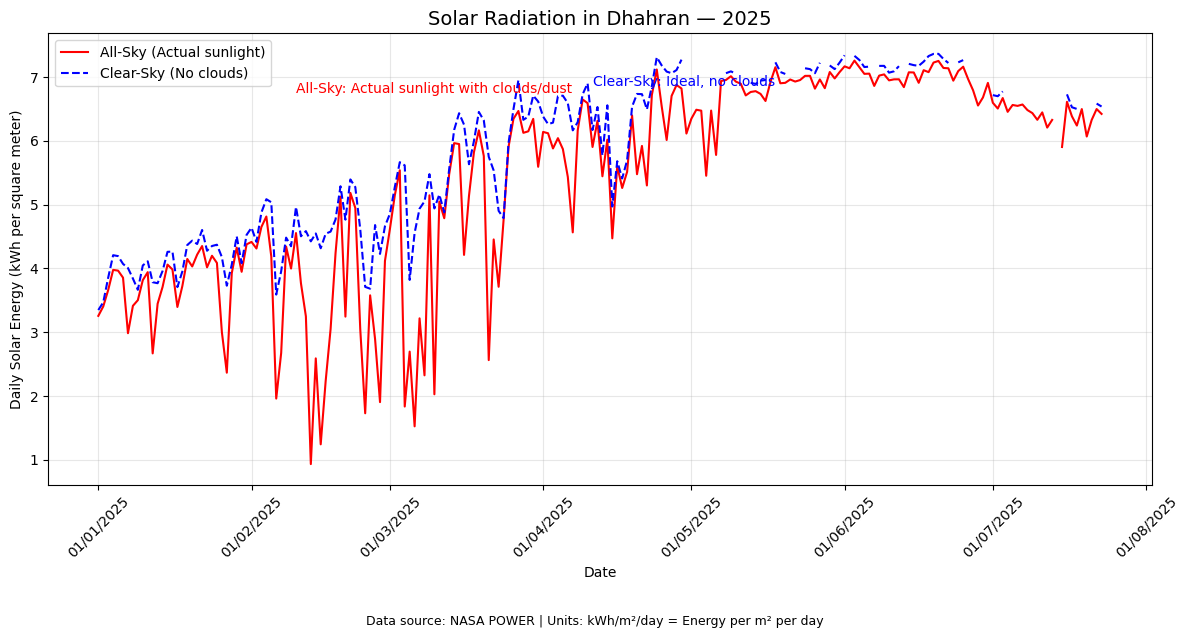

In [ ]:
import matplotlib.dates as mdates
import numpy as np

# Create dates
df['Date'] = pd.date_range(start='2025-01-01', periods=len(df), freq='D')

# Remove bad values
df['ALLSKY'] = df['ALLSKY'].mask(df['ALLSKY'] <= 0, np.nan)
df['CLRSKY'] = df['CLRSKY'].mask(df['CLRSKY'] <= 0, np.nan)

plt.figure(figsize=(12,6))

# Plot
plt.plot(df['Date'], df['ALLSKY'], label='All-Sky (Actual sunlight)', color='red')
plt.plot(df['Date'], df['CLRSKY'], label='Clear-Sky (No clouds)', color='blue', linestyle='--')

# Title & labels
plt.title('Solar Radiation in Dhahran — 2025', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Daily Solar Energy (kWh per square meter)')

# Format x-axis as day/month/year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

# Add explanations near the lines
plt.text(df['Date'].iloc[40], df['ALLSKY'].max()-0.5,
         'All-Sky: Actual sunlight with clouds/dust', color='red')
plt.text(df['Date'].iloc[100], df['CLRSKY'].max()-0.5,
         'Clear-Sky: Ideal, no clouds', color='blue')

plt.legend()
plt.grid(True, alpha=0.3)

# Add data source note
plt.figtext(0.5, -0.05,
            'Data source: NASA POWER | Units: kWh/m²/day = Energy per m² per day',
            wrap=True, ha='center', fontsize=9)

plt.tight_layout()
plt.show()





Dhahran has strong solar potential, especially from late spring through summer when skies are mostly clear.

The gap between All-Sky and Clear-Sky shows how much solar energy is lost to clouds/dust — important for solar power planning.

In [ ]:
print(df.columns.tolist())

['YEAR', 'MO', 'DY', 'ALLSKY', 'PS', 'T2M', 'WS10M', 'CLRSKY', 'Date', 'ALLSKY_smooth', 'CLRSKY_smooth']


In [ ]:
# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Rename
df.rename(columns={
    'ALLSKY_SFC_SW_DWN': 'ALLSKY',
    'CLRSKY_SFC_SW_DWN': 'CLRSKY',
    'YEAR': 'YEAR',
    'MO': 'MO',
    'DY': 'DY'
}, inplace=True)

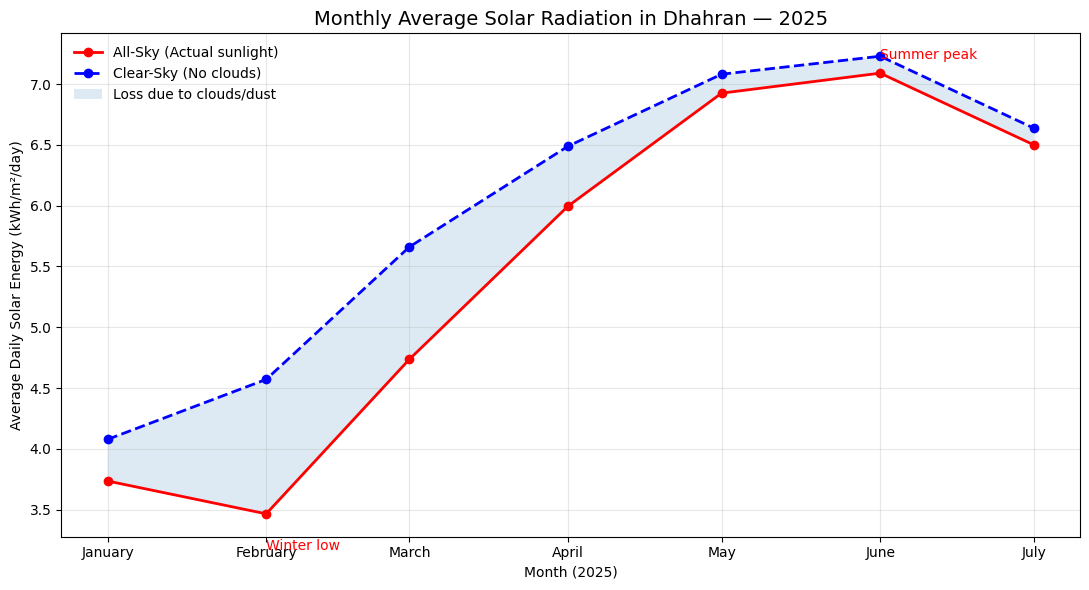

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Monthly means (month start so ticks label the month itself)
monthly = df_clean.resample('MS').mean()

fig, ax = plt.subplots(figsize=(11,6))

# Lines (consistent with your daily plot colors)
ax.plot(monthly.index, monthly['ALLSKY'],
        color='red', linewidth=2, marker='o',
        label='All-Sky (Actual sunlight)')
ax.plot(monthly.index, monthly['CLRSKY'],
        color='blue', linewidth=2, marker='o', linestyle='--',
        label='Clear-Sky (No clouds)')

# Shade the gap = energy lost to clouds/dust
ax.fill_between(
    monthly.index, monthly['ALLSKY'], monthly['CLRSKY'],
    where=(monthly['CLRSKY'] >= monthly['ALLSKY']),
    alpha=0.15, label='Loss due to clouds/dust'
)

# Titles & labels
ax.set_title('Monthly Average Solar Radiation in Dhahran — 2025', fontsize=14)
ax.set_xlabel('Month (2025)')
ax.set_ylabel('Average Daily Solar Energy (kWh/m²/day)')

# X-axis as full month names
ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))

# Light grid + legend
ax.grid(True, alpha=0.3)
ax.legend(frameon=False)
fig.tight_layout()

# Helpful auto-annotations (winter low & summer peak)
peak_idx = monthly['ALLSKY'].idxmax()
low_idx  = monthly['ALLSKY'].idxmin()
ax.annotate('Summer peak',
            xy=(peak_idx, monthly.loc[peak_idx, 'ALLSKY']),
            xytext=(0, 10), textcoords='offset points', color='red')
ax.annotate('Winter low',
            xy=(low_idx, monthly.loc[low_idx, 'ALLSKY']),
            xytext=(0, -18), textcoords='offset points', color='red', va='top')

plt.show()


# **Key patterns:**

**-Winter low (Jan–Feb):**

Solar energy is lowest in February (about 3.5 kWh/m²/day actual).

Larger gap between actual and clear-sky → more cloud cover and/or dust reducing sunlight.

**-Spring increase (Mar–May):**

Steady climb in solar energy as days get longer and skies clear.

By May, actual sunlight is close to the clear-sky maximum — very few losses.

**-Summer peak (June):**

Highest average solar radiation (~7.1 kWh/m²/day actual).

Almost no gap between lines → skies are mostly cloud-free.

**-Early decline (July):**

Slight drop in sunlight, possibly due to seasonal weather shifts.

In [ ]:
plt.savefig('monthly_avg_solar_radiation.png')

<Figure size 640x480 with 0 Axes>

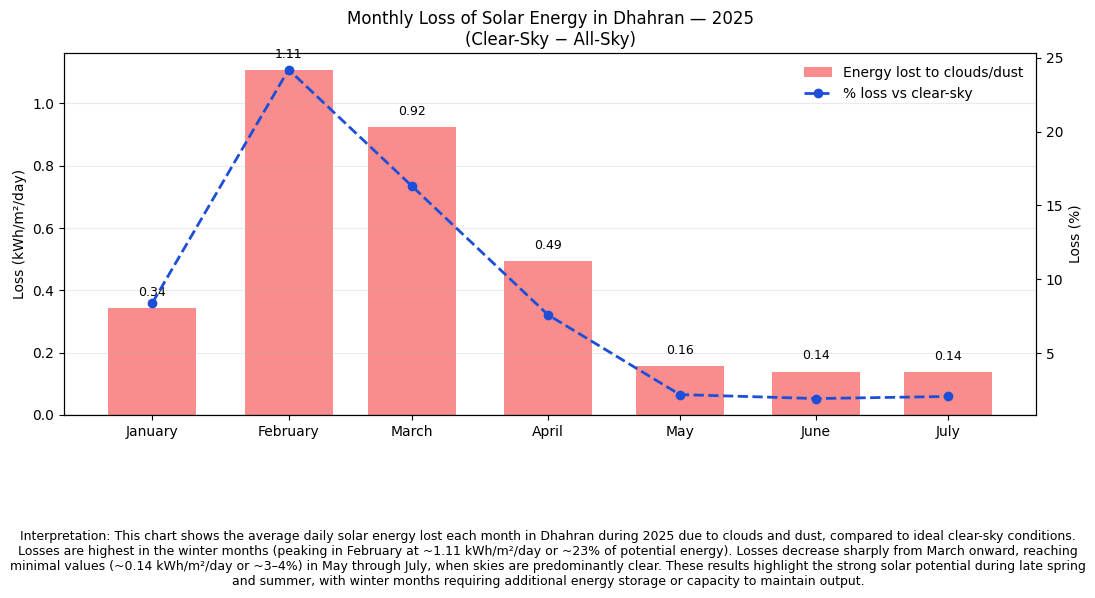

In [ ]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np

# Monthly means
monthly = df_clean.resample('MS').mean()

# Loss due to clouds/dust (positive values for easier reading)
monthly['LOSS'] = monthly['CLRSKY'] - monthly['ALLSKY']
monthly['LOSS_PCT'] = 100 * monthly['LOSS'] / monthly['CLRSKY']

# Create figure and first axis
fig, ax1 = plt.subplots(figsize=(11,6))

# Bars: absolute loss (kWh/m²/day)
bars = ax1.bar(
    monthly.index, monthly['LOSS'],
    width=20, color='#f87171', edgecolor='none', alpha=0.8,
    label='Energy lost to clouds/dust'
)

# Baseline
ax1.axhline(0, color='black', linewidth=0.8)

# Labels and title
ax1.set_ylabel('Loss (kWh/m²/day)')
ax1.set_title('Monthly Loss of Solar Energy in Dhahran — 2025\n(Clear-Sky − All-Sky)')

# X-axis formatting
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%B'))
ax1.grid(True, axis='y', alpha=0.25)

# Add value labels on bars
for rect in bars:
    h = rect.get_height()
    if np.isfinite(h) and h > 0:
        ax1.text(rect.get_x() + rect.get_width()/2, h + 0.03, f'{h:.2f}',
                 ha='center', va='bottom', fontsize=9)

# Secondary axis: percent loss line
ax2 = ax1.twinx()
ax2.plot(monthly.index, monthly['LOSS_PCT'], marker='o', linewidth=2,
         linestyle='--', color='#1d4ed8', label='% loss vs clear-sky')
ax2.set_ylabel('Loss (%)')

# Unified legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, frameon=False, loc='upper right')

# Adjust layout
fig.tight_layout()

# Caption text
caption = (
    "Interpretation: This chart shows the average daily solar energy lost each month in Dhahran during "
    "2025 due to clouds and dust, compared to ideal clear-sky conditions. Losses are highest in the "
    "winter months (peaking in February at ~1.11 kWh/m²/day or ~23% of potential energy). Losses decrease "
    "sharply from March onward, reaching minimal values (~0.14 kWh/m²/day or ~3–4%) in May through July, "
    "when skies are predominantly clear. These results highlight the strong solar potential during late "
    "spring and summer, with winter months requiring additional energy storage or capacity to maintain output."
)

# Add space for caption and insert it into the figure
plt.subplots_adjust(bottom=0.3)
plt.figtext(0.5, 0.02, caption, wrap=True, ha='center', fontsize=9)

# Save figure with caption included
plt.savefig("solar_loss_with_caption.png", dpi=300, bbox_inches="tight")

# Show plot in Colab
plt.show()


